In [1]:
from tika import parser
import re
import timeit
import os
import pandas as pd
import string
import numpy as np
from numpy.linalg import inv


## Clean data##

In [2]:
def generate_raw_data():
    
    """
    This function generates raw text data from FOMC transcripts
    
    returns a list where each element is the full text within each FOMC meeting
    
    It will take about 4-5 minutes
    """

    cwd = os.getcwd() # get current working directory
    base_directory = './FOMC_pdf' # set directory of pdfs
    raw_doc = os.listdir(base_directory) # as above
    filelist = sorted(raw_doc) # sort the pdfs in order
    onlyfiles = [f for f in raw_doc if os.path.isfile(os.path.join(base_directory, f))] # keep if in correct dir
    date = [f[4:10] for f in onlyfiles] # keep the dates in pdfs

    raw_text = pd.DataFrame(columns = ['Date','Speaker', 'content']) #empty dataframe

    start = timeit.default_timer()
    for i,file in enumerate(filelist):
        print('Document {} of {}'.format(i, len(filelist)))
        
        parsed = parser.from_file(os.path.join(cwd, 'FOMC_pdf',file)) # parse the pdf
        interjections = re.split('\nMR. |\nMS. |\nCHAIRMAN |\nVICE CHAIRMAN ', parsed['content']) # split the entire string by the names (looking for MR, MS, Chairman or Vice Chairman)
        temp_df = pd.DataFrame(columns = ['Date','Speaker','content']) # create a temporary dataframe
        interjections = [interjection.replace('\n',' ') for interjection in interjections] # replace \n linebreaks with spaces
        temp = [re.split('(^\S*)', interjection.lstrip()) for interjection in interjections] # changed to this split because sometimes (rarely) there was not a period, either other punctuation or whitespace
        
        speaker = []
        content = []
        for interjection in temp:
            speaker.append(interjection[1].strip(string.punctuation))
            content.append(interjection[2])
            
        temp_df['Speaker'] = speaker

        temp_df['content'] = content # save interjections

        temp_df['Date'] = date[i]
        raw_text = pd.concat([raw_text, temp_df], ignore_index = True)

    end = timeit.default_timer()
    raw_text.index = raw_text['Date'] # set dataframe index to the Date
    raw_text.to_excel('raw_text.xlsx') # save as raw_text.xlsx

    print("Documents processed. Time: {}".format(end - start))
    
    return raw_text


In [3]:
import pandas as pd
import topicmodels
import numpy as np
from nltk.stem import PorterStemmer
import nltk
from nltk.collocations import *

def preprocess():
    
    
    '''
    main function for preprocessing
        
    This function writes the tokenized documents, which includes columns of 
    
    Date: date of the meeting
    Section: FOMC1 or FOMC2
    Speaker: speaker of the interjection
    content: list of tokens in the interjection
    
    '''
    
    
    text = pd.read_excel('raw_text.xlsx')
    
    text_separated = separation(text)
    
    text_separated_col = find_collocation(text_separated)
    text_separated_col['content'] = tokenize(text_separated_col['content'].values)
    text_separated_col.to_excel('FOMC_token_separated_col.xlsx')
    
def tokenize(content):
    '''
    Code for tokenization:
        1. remove words with length of 1
        2. remove non-alphabetical words
        3. remove stop words
        4. stem all words
    '''
    FOMC_token = []
    for statement in content:
        statement = statement.lower()
        docsobj = topicmodels.RawDocs([statement], "long")
        docsobj.token_clean(1)
        docsobj.stopword_remove("tokens")
        docsobj.stem()
        docsobj.stopword_remove("stems")
        ps = PorterStemmer()
        FOMC_token.append(' '.join([ps.stem(word) for word in docsobj.tokens[0]]))
        
    return FOMC_token

def separation(raw_text):
    
    separation_rule = pd.read_excel('Separation.xlsx', index_col = 0)
    
    FOMC_separation = pd.DataFrame(columns = ['Date','Speaker','content','Section'])
    for i in separation_rule.index:

        temp1 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC1_start'][i]:separation_rule['FOMC1_end'][i]]
        temp1['Section'] = 1
        if separation_rule['FOMC2_end'][i] == 'end':
            temp2 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC2_start'][i]:]
        else:
            temp2 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC2_start'][i]:separation_rule['FOMC2_end'][i]]
        temp2['Section'] = 2
        FOMC_separation = FOMC_separation.append(temp1, ignore_index=True)
        FOMC_separation = FOMC_separation.append(temp2, ignore_index = True)
        
    FOMC_separation.to_excel('raw_text_separated.xlsx')
    return FOMC_separation

def find_collocation(raw_text_separated):
    
    content = raw_text_separated['content'].apply(lambda x: re.sub(r'[^\w\s]','',x)) #remove punctuations
    
    big_document = content.apply(lambda x: x.split(' ')).values
    
    bigram_list = bigrams(big_document)
    trigram_list = trigram(big_document)
    
    replace_word = [''.join(x.split(' ')) + 'xx' for x in bigram_list] + [''.join(x.split(' ')) + 'xxx' for x in trigram_list]
    
    dict_collocation = dict(zip(bigram_list + trigram_list, replace_word))

    content = content.apply(lambda x: replace_collocation(x, dict_collocation))
    
    raw_text_separated['content'] = content
    raw_text_separated.to_excel('FOMC_separated_Collocation.xlsx')
    return raw_text_separated

def bigrams(big_document):
    
    ignored_words = nltk.corpus.stopwords.words('english')
    ignored_words.append('percent')
    ignored_words.append('governor')
    ignored_words.append('dont')
    bigram_measures = nltk.collocations.BigramAssocMeasures()

    finder = BigramCollocationFinder.from_documents(big_document)
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
    finder.apply_freq_filter(150)
    
    return [' '.join(x) for x in list(finder.ngram_fd.keys())]


def trigram(big_document):
    
    ignored_words = nltk.corpus.stopwords.words('english')
    ignored_words.append('percent')
    ignored_words.append('governor')
    ignored_words.append('dont')
    trigram_measures = nltk.collocations.TrigramAssocMeasures()

    finder = TrigramCollocationFinder.from_documents(big_document)
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
    finder.apply_freq_filter(100)
    
    return [' '.join(x) for x in list(finder.ngram_fd.keys())]

def replace_collocation(string, dict_collocation):
    
    for key in dict_collocation.keys():
        
        string = string.replace(key, dict_collocation[key])
        
    return string

In [218]:
preprocess()

C:\Users\barry\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt

def generate_term_document_interjection(option = None):
    '''
    option = 'text' or 'matrix' for return options
    
    '''
    data = pd.read_excel('FOMC_token_separated_col.xlsx')
    texts = []
    for line in data['content'].fillna(' ').values:
        texts.append(line.split(' '))
        
    dictionary2 = corpora.Dictionary(texts)
    corpus2 = [dictionary2.doc2bow(text) for text in texts]
    
    term_document2 = gensim.matutils.corpus2dense(corpus2, num_terms=len(dictionary2.keys()))
    
    TF = 1+np.log(term_document2.sum(axis = 1))
    IDF = np.log(term_document2.shape[1] / np.count_nonzero(term_document2, axis = 1))

    TF_IDF = pd.Series(dict(zip(dictionary2.keys(), TF*IDF)))
    
    # use top 9000 in TF-IDF
    keys_to_use2 = TF_IDF.sort_values(ascending = False)[:9000].index.values
    
    TF_IDF.sort_values(ascending = False).reset_index()[0].plot()
    plt.show()
    
    dictionary2.filter_tokens(good_ids = keys_to_use2)
    
    #pd.Series(dictionary2.token2id).to_csv('dictionary.csv')
    
    new_text = []
    for line in texts:
        new_text.append([x for x in line if x in dictionary2.token2id.keys()])
    
    new_corpus2 = [dictionary2.doc2bow(text) for text in texts]
    new_term_document2 = gensim.matutils.corpus2dense(new_corpus2, num_terms=len(dictionary2.keys()))
    
    #pd.DataFrame(new_term_document2).to_csv('Matrix_interjection_tfidf.csv')
    
    if option == 'text':
        return new_text
    elif option == 'matrix':
        return new_term_document2
    else:
        return None

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [5]:
def generate_term_document_meeting(option = None, section = None):
    '''
    option = 'text' or 'matrix' for return options
    
    '''
    
    data = pd.read_excel('FOMC_token_separated_col.xlsx')
    data = data.dropna()
    meeting_text = []
    
    if all([section != 1, section!=2]):
        print('Enter valid section number')
        return None
    
    for meeting in data['Date'].unique():
        meeting_text.append(' '.join(data.groupby('Date').get_group(meeting).groupby('Section').get_group(section)['content'].values).split(' '))
        
    dictionary = corpora.Dictionary(meeting_text)
    corpus = [dictionary.doc2bow(text) for text in meeting_text]
    
    term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary.keys()))
    
    TF = 1+np.log(term_document.sum(axis = 1))
    IDF = np.log(term_document.shape[1] / np.count_nonzero(term_document, axis = 1))

    TF_IDF = pd.Series(dict(zip(dictionary.keys(), TF*IDF)))
    
    # use top 9000 in TF-IDF
    keys_to_use = TF_IDF.sort_values(ascending = False)[:9000].index.values
    
    #TF_IDF.sort_values(ascending = False).reset_index()[0].plot()
    #plt.show()
    
    dictionary.filter_tokens(good_ids = keys_to_use)
    
    pd.Series(dictionary.token2id).to_csv('dictionary_meeting.csv')
    
    new_text = []
    for line in meeting_text:
        new_text.append([x for x in line if x in dictionary.token2id.keys()])
    
    new_corpus = [dictionary.doc2bow(text) for text in meeting_text]
    new_term_document = gensim.matutils.corpus2dense(new_corpus, num_terms=len(dictionary.keys()))
    
    pd.DataFrame(new_term_document).to_csv('FOMC' + str(section) + '_meeting_matrix.csv')
    
    if option == 'text':
        return new_text
    elif option == 'matrix':
        return new_term_document
    else:
        return None

In [6]:
text_FOMC1 = generate_term_document_meeting('text',1)
text_FOMC2 = generate_term_document_meeting('text',2)

C:\Users\barry\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


## LDA Implementation##

In [7]:
import topicmodels

In [8]:
topicmodels.LDA.LDAGibbs?

In [9]:
# 40 topics
ldaobj1 = topicmodels.LDA.LDAGibbs(text_FOMC1,40)

In [10]:
# Gibbs sampling
# using the strategy in HMP (4000 burning, sample every 50 trials for total of 4000 trials)
ldaobj1.sample(4000,80,50)

Iteration 10 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 30 of (collapsed) Gibbs sampling
Iteration 40 of (collapsed) Gibbs sampling
Iteration 50 of (collapsed) Gibbs sampling
Iteration 60 of (collapsed) Gibbs sampling
Iteration 70 of (collapsed) Gibbs sampling
Iteration 80 of (collapsed) Gibbs sampling
Iteration 90 of (collapsed) Gibbs sampling
Iteration 100 of (collapsed) Gibbs sampling
Iteration 110 of (collapsed) Gibbs sampling
Iteration 120 of (collapsed) Gibbs sampling
Iteration 130 of (collapsed) Gibbs sampling
Iteration 140 of (collapsed) Gibbs sampling
Iteration 150 of (collapsed) Gibbs sampling
Iteration 160 of (collapsed) Gibbs sampling
Iteration 170 of (collapsed) Gibbs sampling
Iteration 180 of (collapsed) Gibbs sampling
Iteration 190 of (collapsed) Gibbs sampling
Iteration 200 of (collapsed) Gibbs sampling
Iteration 210 of (collapsed) Gibbs sampling
Iteration 220 of (collapsed) Gibbs sampling
Iteration 230 of (collapsed) Gibbs sampli

Iteration 1860 of (collapsed) Gibbs sampling
Iteration 1870 of (collapsed) Gibbs sampling
Iteration 1880 of (collapsed) Gibbs sampling
Iteration 1890 of (collapsed) Gibbs sampling
Iteration 1900 of (collapsed) Gibbs sampling
Iteration 1910 of (collapsed) Gibbs sampling
Iteration 1920 of (collapsed) Gibbs sampling
Iteration 1930 of (collapsed) Gibbs sampling
Iteration 1940 of (collapsed) Gibbs sampling
Iteration 1950 of (collapsed) Gibbs sampling
Iteration 1960 of (collapsed) Gibbs sampling
Iteration 1970 of (collapsed) Gibbs sampling
Iteration 1980 of (collapsed) Gibbs sampling
Iteration 1990 of (collapsed) Gibbs sampling
Iteration 2000 of (collapsed) Gibbs sampling
Iteration 2010 of (collapsed) Gibbs sampling
Iteration 2020 of (collapsed) Gibbs sampling
Iteration 2030 of (collapsed) Gibbs sampling
Iteration 2040 of (collapsed) Gibbs sampling
Iteration 2050 of (collapsed) Gibbs sampling
Iteration 2060 of (collapsed) Gibbs sampling
Iteration 2070 of (collapsed) Gibbs sampling
Iteration 

Iteration 3690 of (collapsed) Gibbs sampling
Iteration 3700 of (collapsed) Gibbs sampling
Iteration 3710 of (collapsed) Gibbs sampling
Iteration 3720 of (collapsed) Gibbs sampling
Iteration 3730 of (collapsed) Gibbs sampling
Iteration 3740 of (collapsed) Gibbs sampling
Iteration 3750 of (collapsed) Gibbs sampling
Iteration 3760 of (collapsed) Gibbs sampling
Iteration 3770 of (collapsed) Gibbs sampling
Iteration 3780 of (collapsed) Gibbs sampling
Iteration 3790 of (collapsed) Gibbs sampling
Iteration 3800 of (collapsed) Gibbs sampling
Iteration 3810 of (collapsed) Gibbs sampling
Iteration 3820 of (collapsed) Gibbs sampling
Iteration 3830 of (collapsed) Gibbs sampling
Iteration 3840 of (collapsed) Gibbs sampling
Iteration 3850 of (collapsed) Gibbs sampling
Iteration 3860 of (collapsed) Gibbs sampling
Iteration 3870 of (collapsed) Gibbs sampling
Iteration 3880 of (collapsed) Gibbs sampling
Iteration 3890 of (collapsed) Gibbs sampling
Iteration 3900 of (collapsed) Gibbs sampling
Iteration 

Iteration 5520 of (collapsed) Gibbs sampling
Iteration 5530 of (collapsed) Gibbs sampling
Iteration 5540 of (collapsed) Gibbs sampling
Iteration 5550 of (collapsed) Gibbs sampling
Iteration 5560 of (collapsed) Gibbs sampling
Iteration 5570 of (collapsed) Gibbs sampling
Iteration 5580 of (collapsed) Gibbs sampling
Iteration 5590 of (collapsed) Gibbs sampling
Iteration 5600 of (collapsed) Gibbs sampling
Iteration 5610 of (collapsed) Gibbs sampling
Iteration 5620 of (collapsed) Gibbs sampling
Iteration 5630 of (collapsed) Gibbs sampling
Iteration 5640 of (collapsed) Gibbs sampling
Iteration 5650 of (collapsed) Gibbs sampling
Iteration 5660 of (collapsed) Gibbs sampling
Iteration 5670 of (collapsed) Gibbs sampling
Iteration 5680 of (collapsed) Gibbs sampling
Iteration 5690 of (collapsed) Gibbs sampling
Iteration 5700 of (collapsed) Gibbs sampling
Iteration 5710 of (collapsed) Gibbs sampling
Iteration 5720 of (collapsed) Gibbs sampling
Iteration 5730 of (collapsed) Gibbs sampling
Iteration 

Iteration 7350 of (collapsed) Gibbs sampling
Iteration 7360 of (collapsed) Gibbs sampling
Iteration 7370 of (collapsed) Gibbs sampling
Iteration 7380 of (collapsed) Gibbs sampling
Iteration 7390 of (collapsed) Gibbs sampling
Iteration 7400 of (collapsed) Gibbs sampling
Iteration 7410 of (collapsed) Gibbs sampling
Iteration 7420 of (collapsed) Gibbs sampling
Iteration 7430 of (collapsed) Gibbs sampling
Iteration 7440 of (collapsed) Gibbs sampling
Iteration 7450 of (collapsed) Gibbs sampling
Iteration 7460 of (collapsed) Gibbs sampling
Iteration 7470 of (collapsed) Gibbs sampling
Iteration 7480 of (collapsed) Gibbs sampling
Iteration 7490 of (collapsed) Gibbs sampling
Iteration 7500 of (collapsed) Gibbs sampling
Iteration 7510 of (collapsed) Gibbs sampling
Iteration 7520 of (collapsed) Gibbs sampling
Iteration 7530 of (collapsed) Gibbs sampling
Iteration 7540 of (collapsed) Gibbs sampling
Iteration 7550 of (collapsed) Gibbs sampling
Iteration 7560 of (collapsed) Gibbs sampling
Iteration 

In [11]:
# theta matrix
ldaobj1.dt_avg()

array([[0.01273267, 0.00980198, 0.01106931, ..., 0.06041584, 0.01225743,
        0.02445545],
       [0.04381173, 0.03143519, 0.03304012, ..., 0.0100463 , 0.01066358,
        0.01063272],
       [0.01907029, 0.00959184, 0.0054195 , ..., 0.02219955, 0.00641723,
        0.01267574],
       ...,
       [0.01070175, 0.00247563, 0.01201429, ..., 0.00623132, 0.02192982,
        0.03834308],
       [0.00711438, 0.00328423, 0.02090988, ..., 0.01252166, 0.01163778,
        0.07468804],
       [0.00301967, 0.00257485, 0.00753636, ..., 0.01215569, 0.00615056,
        0.00751925]])

In [12]:
#ldaobj.alpha
#ldaobj.beta

In [266]:
# B matrix
ldaobj1.tt_avg()

array([[4.50864723e-05, 1.85616734e-05, 1.28374261e-05, ...,
        7.47881743e-05, 2.30787434e-05, 2.26571095e-04],
       [1.06312834e-05, 1.80032910e-05, 1.30494675e-05, ...,
        1.28519440e-05, 2.91426573e-05, 7.60965288e-06],
       [5.66357349e-06, 8.97394564e-06, 6.92201649e-06, ...,
        6.76921894e-06, 8.23055784e-06, 7.60965288e-06],
       ...,
       [5.66357349e-06, 8.97394564e-06, 1.90927098e-05, ...,
        6.76921894e-06, 3.82541320e-05, 2.49780724e-04],
       [5.53768366e-05, 1.66573878e-05, 2.02862573e-05, ...,
        6.76921894e-06, 2.28933144e-05, 1.46892989e-05],
       [1.11460296e-05, 8.97394564e-06, 7.01185989e-05, ...,
        1.88192308e-05, 8.23055784e-06, 7.60965288e-06]])

In [269]:
ldaobj1.perplexity()

array([2393.27100308, 2388.11174357, 2394.58094689, 2387.01837391,
       2400.21255281, 2393.22493428, 2393.52464741, 2389.52338968,
       2389.22274421, 2395.79741177, 2393.38503353, 2392.36960863,
       2386.18584199, 2399.02215387, 2391.69513172, 2394.05587286,
       2393.44703478, 2391.75322447, 2395.22163304, 2384.37172776,
       2390.85477101, 2393.15138599, 2394.51019288, 2398.06557499,
       2389.74604094, 2386.0087111 , 2390.49577374, 2392.51365289,
       2390.86594321, 2395.53654099, 2396.98290016, 2394.62742222,
       2401.30748477, 2386.38380296, 2385.46894824, 2392.18945537,
       2387.99011996, 2389.39018682, 2388.62505063, 2390.25396964,
       2391.09065893, 2388.72707181, 2389.5197864 , 2395.28032082,
       2387.06995195, 2392.72846318, 2393.82746469, 2385.28713356,
       2387.60456078, 2386.7469772 ])

In [13]:
#only keep the last 5 samples
ldaobj1.samples_keep(5)

In [14]:
LDA_FOMC1_theta = ldaobj1.dt_avg()

In [15]:
HHI_FOMC1 = (LDA_FOMC1_theta**2).sum(axis = 1)

In [16]:
ldaobj2 = topicmodels.LDA.LDAGibbs(text_FOMC2,40)
ldaobj2.sample(4000,80,50)
ldaobj2.samples_keep(5)
LDA_FOMC2_theta = ldaobj2.dt_avg()

Iteration 10 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 30 of (collapsed) Gibbs sampling
Iteration 40 of (collapsed) Gibbs sampling
Iteration 50 of (collapsed) Gibbs sampling
Iteration 60 of (collapsed) Gibbs sampling
Iteration 70 of (collapsed) Gibbs sampling
Iteration 80 of (collapsed) Gibbs sampling
Iteration 90 of (collapsed) Gibbs sampling
Iteration 100 of (collapsed) Gibbs sampling
Iteration 110 of (collapsed) Gibbs sampling
Iteration 120 of (collapsed) Gibbs sampling
Iteration 130 of (collapsed) Gibbs sampling
Iteration 140 of (collapsed) Gibbs sampling
Iteration 150 of (collapsed) Gibbs sampling
Iteration 160 of (collapsed) Gibbs sampling
Iteration 170 of (collapsed) Gibbs sampling
Iteration 180 of (collapsed) Gibbs sampling
Iteration 190 of (collapsed) Gibbs sampling
Iteration 200 of (collapsed) Gibbs sampling
Iteration 210 of (collapsed) Gibbs sampling
Iteration 220 of (collapsed) Gibbs sampling
Iteration 230 of (collapsed) Gibbs sampli

Iteration 1860 of (collapsed) Gibbs sampling
Iteration 1870 of (collapsed) Gibbs sampling
Iteration 1880 of (collapsed) Gibbs sampling
Iteration 1890 of (collapsed) Gibbs sampling
Iteration 1900 of (collapsed) Gibbs sampling
Iteration 1910 of (collapsed) Gibbs sampling
Iteration 1920 of (collapsed) Gibbs sampling
Iteration 1930 of (collapsed) Gibbs sampling
Iteration 1940 of (collapsed) Gibbs sampling
Iteration 1950 of (collapsed) Gibbs sampling
Iteration 1960 of (collapsed) Gibbs sampling
Iteration 1970 of (collapsed) Gibbs sampling
Iteration 1980 of (collapsed) Gibbs sampling
Iteration 1990 of (collapsed) Gibbs sampling
Iteration 2000 of (collapsed) Gibbs sampling
Iteration 2010 of (collapsed) Gibbs sampling
Iteration 2020 of (collapsed) Gibbs sampling
Iteration 2030 of (collapsed) Gibbs sampling
Iteration 2040 of (collapsed) Gibbs sampling
Iteration 2050 of (collapsed) Gibbs sampling
Iteration 2060 of (collapsed) Gibbs sampling
Iteration 2070 of (collapsed) Gibbs sampling
Iteration 

Iteration 3690 of (collapsed) Gibbs sampling
Iteration 3700 of (collapsed) Gibbs sampling
Iteration 3710 of (collapsed) Gibbs sampling
Iteration 3720 of (collapsed) Gibbs sampling
Iteration 3730 of (collapsed) Gibbs sampling
Iteration 3740 of (collapsed) Gibbs sampling
Iteration 3750 of (collapsed) Gibbs sampling
Iteration 3760 of (collapsed) Gibbs sampling
Iteration 3770 of (collapsed) Gibbs sampling
Iteration 3780 of (collapsed) Gibbs sampling
Iteration 3790 of (collapsed) Gibbs sampling
Iteration 3800 of (collapsed) Gibbs sampling
Iteration 3810 of (collapsed) Gibbs sampling
Iteration 3820 of (collapsed) Gibbs sampling
Iteration 3830 of (collapsed) Gibbs sampling
Iteration 3840 of (collapsed) Gibbs sampling
Iteration 3850 of (collapsed) Gibbs sampling
Iteration 3860 of (collapsed) Gibbs sampling
Iteration 3870 of (collapsed) Gibbs sampling
Iteration 3880 of (collapsed) Gibbs sampling
Iteration 3890 of (collapsed) Gibbs sampling
Iteration 3900 of (collapsed) Gibbs sampling
Iteration 

Iteration 5520 of (collapsed) Gibbs sampling
Iteration 5530 of (collapsed) Gibbs sampling
Iteration 5540 of (collapsed) Gibbs sampling
Iteration 5550 of (collapsed) Gibbs sampling
Iteration 5560 of (collapsed) Gibbs sampling
Iteration 5570 of (collapsed) Gibbs sampling
Iteration 5580 of (collapsed) Gibbs sampling
Iteration 5590 of (collapsed) Gibbs sampling
Iteration 5600 of (collapsed) Gibbs sampling
Iteration 5610 of (collapsed) Gibbs sampling
Iteration 5620 of (collapsed) Gibbs sampling
Iteration 5630 of (collapsed) Gibbs sampling
Iteration 5640 of (collapsed) Gibbs sampling
Iteration 5650 of (collapsed) Gibbs sampling
Iteration 5660 of (collapsed) Gibbs sampling
Iteration 5670 of (collapsed) Gibbs sampling
Iteration 5680 of (collapsed) Gibbs sampling
Iteration 5690 of (collapsed) Gibbs sampling
Iteration 5700 of (collapsed) Gibbs sampling
Iteration 5710 of (collapsed) Gibbs sampling
Iteration 5720 of (collapsed) Gibbs sampling
Iteration 5730 of (collapsed) Gibbs sampling
Iteration 

Iteration 7350 of (collapsed) Gibbs sampling
Iteration 7360 of (collapsed) Gibbs sampling
Iteration 7370 of (collapsed) Gibbs sampling
Iteration 7380 of (collapsed) Gibbs sampling
Iteration 7390 of (collapsed) Gibbs sampling
Iteration 7400 of (collapsed) Gibbs sampling
Iteration 7410 of (collapsed) Gibbs sampling
Iteration 7420 of (collapsed) Gibbs sampling
Iteration 7430 of (collapsed) Gibbs sampling
Iteration 7440 of (collapsed) Gibbs sampling
Iteration 7450 of (collapsed) Gibbs sampling
Iteration 7460 of (collapsed) Gibbs sampling
Iteration 7470 of (collapsed) Gibbs sampling
Iteration 7480 of (collapsed) Gibbs sampling
Iteration 7490 of (collapsed) Gibbs sampling
Iteration 7500 of (collapsed) Gibbs sampling
Iteration 7510 of (collapsed) Gibbs sampling
Iteration 7520 of (collapsed) Gibbs sampling
Iteration 7530 of (collapsed) Gibbs sampling
Iteration 7540 of (collapsed) Gibbs sampling
Iteration 7550 of (collapsed) Gibbs sampling
Iteration 7560 of (collapsed) Gibbs sampling
Iteration 

In [17]:
HHI_FOMC2 = (LDA_FOMC2_theta**2).sum(axis = 1)

## NMF with ANLS

using numba

In [1]:
import numba
@numba.jit
def NMF_ANLS_full(P,k):

    B = np.random.uniform(low = 1, high = 1000,size = (P.shape[0], k))
    B = B/B.sum(axis = 0)

    return B, NMF_ANLS(B,P)

@numba.jit
def NMF_ANLS(B, P):
    
    theta = np.zeros(shape = (B.shape[1],P.shape[1]))
    
    for i,column in enumerate(P.T):
        theta[:,i] = ANLS_column(B, column)
        
    return theta

@numba.jit
def ANLS_column(B, y):
    
    m,n = B.shape
    g = np.zeros(n)
    E = np.arange(n)
    S = np.array([])
    w = np.matmul(B.T, y-np.matmul(B,g))
    

    while len(E) != 0 and w[E].max() > 0:
        
        t = w[E].argmax()
        E = np.delete(E, t).astype(int)
        S = np.append(S,t).astype(int)
        
        Bs = B.copy()
        Bs[:,E] = 0
        
        z = np.linalg.lstsq(Bs, y, rcond=None)[0]
        z[E] = 0

        while z[S].max() <= 0:
            
            alpha = (g/(g-z))[S].min()
            
            g = g + alpha*(z-g)
            
            s_move = S[g[S] == 0]
            S = np.delete(S, s_move).astype(int)
            E = np.append(E, s_move).astype(int)
            Bs = B.copy()
            Bs[:,E] = 0            
            z = np.linalg.lstsq(Bs, y, rcond=None)[0]
            #z[E] = 0
        g = z
        w = np.matmul(B.T, y-np.matmul(B,g))
    
    return g

In [19]:
td_matrix_FOMC1_pd = pd.read_csv('FOMC1_meeting_matrix.csv', index_col = 0)
td_matrix_FOMC1_pd = td_matrix_FOMC1_pd.replace(0,1e-10)
td_matrix_value1 = td_matrix_FOMC1_pd.values
td_matrix1 = td_matrix_value1 / td_matrix_value1.sum(axis = 0)

In [20]:
td_matrix_FOMC2_pd = pd.read_csv('FOMC2_meeting_matrix.csv', index_col = 0)
td_matrix_FOMC2_pd = td_matrix_FOMC2_pd.replace(0,1e-10)
td_matrix_value2 = td_matrix_FOMC2_pd.values
td_matrix2 = td_matrix_value2 / td_matrix_value2.sum(axis = 0)

In [231]:
# one NMF for FOMC2 meeting matrix
B, theta = NMF_ANLS_full(td_matrix2, 40)

In [232]:
B

array([[2.13890256e-04, 6.61420228e-05, 1.51255276e-04, ...,
        1.48322934e-04, 2.08726418e-04, 1.39659090e-04],
       [1.50005373e-04, 1.99426852e-04, 8.67976603e-05, ...,
        5.42133028e-05, 1.90499579e-04, 1.48363164e-04],
       [2.12619157e-05, 7.03627384e-05, 6.24533236e-05, ...,
        8.39357789e-05, 2.57589314e-05, 1.34813644e-04],
       ...,
       [1.65799225e-04, 9.01210715e-05, 1.70403435e-04, ...,
        1.86791695e-04, 1.10054203e-04, 1.46190181e-04],
       [1.33311910e-04, 1.09595634e-04, 5.58064264e-05, ...,
        1.46261032e-04, 2.17790508e-04, 9.68391448e-05],
       [4.31294144e-05, 7.36010889e-05, 2.20318193e-04, ...,
        1.15250210e-04, 1.67249051e-04, 9.44309758e-05]])

In [233]:
theta

array([[0.03858995, 0.        , 0.0997544 , ..., 0.        , 0.0403837 ,
        0.        ],
       [0.04086689, 0.        , 0.        , ..., 0.06134365, 0.14280283,
        0.02828285],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00347513,
        0.01373707],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.09583669,
        0.11858449],
       [0.        , 0.        , 0.        , ..., 0.02360189, 0.        ,
        0.08490225],
       [0.        , 0.08099341, 0.14897164, ..., 0.00609038, 0.        ,
        0.        ]])

### KL-divergence non-increasing updating

In [234]:
@numba.jit
def WKLNMF(P, k, eps, maxit):
    V, D = P.shape
    W = P

    B = np.random.uniform(1e-5,1,size = (V, k))
    B = B / B.sum(axis = 0)

    Theta = np.random.uniform(1e-5,1,size = (k, D))
    Theta = Theta/Theta.sum(axis = 0)
    
    KL_div_prev = np.inf
    for i in numba.prange(maxit):
        Theta = (Theta/np.matmul(B.T,W))*np.matmul(B.T,(W*P)/np.matmul(B,Theta))
        B = (B/np.matmul(W, Theta.T))*np.matmul((W*P)/np.matmul(B, Theta), Theta.T)
        KL_div = KL(W,P,B,Theta)
        if abs(KL_div_prev - KL_div) < eps:
            print("converged after {}".format(str(i)))
            break
        KL_div_prev = KL_div
    
    B_norm = B/B.sum(axis = 0)
    Theta_norm = Theta/Theta.sum(axis = 0)
    return B_norm, Theta_norm

@numba.jit
def KL(W,P,B,Theta):
    loss = 0
    P_hat = np.matmul(B, Theta)
    
    loss = np.sum(W*(P*np.log(P/P_hat) - P + P_hat))
            
    return loss



In [235]:
B1, theta1 = WKLNMF(td_matrix1, 40, 1e-5,1000)
B2, theta2 = WKLNMF(td_matrix2, 40, 1e-5,1000)

converged after 177
converged after 224


What is the functional to report?

Herfindahl index over topic composition in each meeting (how concentrated topics in each meeting)

In [21]:
stem_num1 = td_matrix_FOMC1_pd.replace(1e-10,0).sum(axis = 0).values
stem_num2 = td_matrix_FOMC2_pd.replace(1e-10,0).sum(axis = 0).values

In [23]:
import statsmodels.api as sm
def band(P, k, eps, maxit, M, stem_num):
    
    record = np.zeros((M, P.shape[1]))
    covariates = pd.read_csv('covariates.csv')
    covariates['num_stems'] = stem_num
    covariates['Intercept'] = 1
    params = pd.DataFrame(index = range(M), columns = ['Transparency','Recession','EPU','Twoday','PhDs', 'num_stems','Intercept'])
    bse = pd.DataFrame(index = range(M), columns = ['Transparency','Recession','EPU','Twoday','PhDs', 'num_stems','Intercept'])

    for m in range(M):
        print('Trial number {}'.format(str(m)))
        
        B, Theta = WKLNMF(P, k, eps,maxit)
        HHI = (Theta**2).sum(axis = 0)
        record[m] = HHI
        model = sm.OLS(HHI, covariates[['Transparency','Recession','EPU','Twoday','PhDs', 'num_stems', 'Intercept']].values).fit()
        params.loc[m] = model.params
        bse.loc[m] = model.bse
        
    return record, params, bse
        

In [287]:
Herfindahl1, params1, bse1 = band(td_matrix1,40,1e-5,1000,120, stem_num1)

Trial number 0
converged after 180
Trial number 1
converged after 177
Trial number 2
converged after 177
Trial number 3
converged after 173
Trial number 4
converged after 181
Trial number 5
converged after 176
Trial number 6
converged after 173
Trial number 7
converged after 170
Trial number 8
converged after 178
Trial number 9
converged after 178
Trial number 10
converged after 180
Trial number 11
converged after 176
Trial number 12
converged after 180
Trial number 13
converged after 186
Trial number 14
converged after 170
Trial number 15
converged after 175
Trial number 16
converged after 184
Trial number 17
converged after 171
Trial number 18
converged after 180
Trial number 19
converged after 178
Trial number 20
converged after 179
Trial number 21
converged after 179
Trial number 22
converged after 190
Trial number 23
converged after 177
Trial number 24
converged after 175
Trial number 25
converged after 171
Trial number 26
converged after 179
Trial number 27
converged after 188
Tr

In [292]:
Herfindahl2, params2, bse2 = band(td_matrix2,40,1e-5,1000,120, stem_num2)

Trial number 0
converged after 242
Trial number 1
converged after 231
Trial number 2
converged after 226
Trial number 3
converged after 221
Trial number 4
converged after 223
Trial number 5
converged after 231
Trial number 6
converged after 214
Trial number 7
converged after 228
Trial number 8
converged after 226
Trial number 9
converged after 223
Trial number 10
converged after 223
Trial number 11
converged after 232
Trial number 12
converged after 220
Trial number 13
converged after 221
Trial number 14
converged after 238
Trial number 15
converged after 235
Trial number 16
converged after 232
Trial number 17
converged after 234
Trial number 18
converged after 223
Trial number 19
converged after 228
Trial number 20
converged after 216
Trial number 21
converged after 218
Trial number 22
converged after 222
Trial number 23
converged after 227
Trial number 24
converged after 232
Trial number 25
converged after 218
Trial number 26
converged after 214
Trial number 27
converged after 226
Tr

<IPython.core.display.Javascript object>


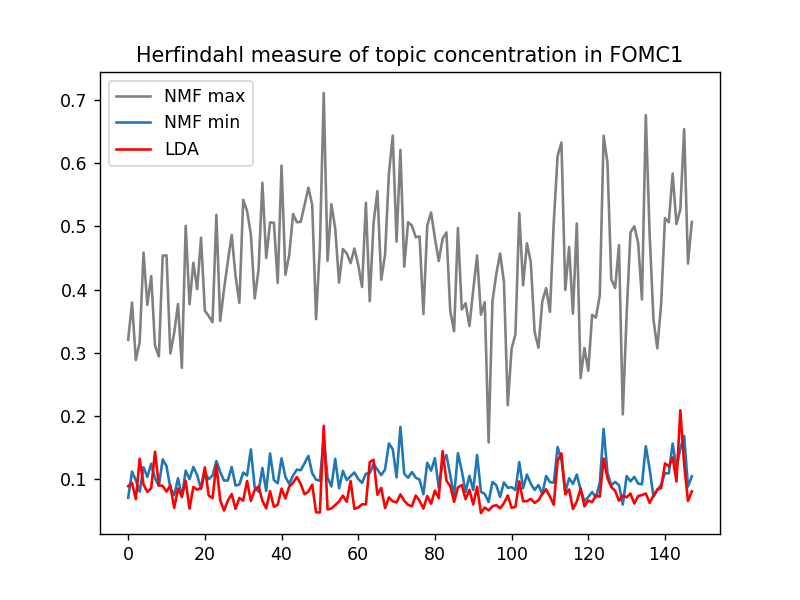

In [288]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(Herfindahl1.max(axis = 0), c = 'grey', label = 'NMF max')
plt.plot(Herfindahl1.min(axis = 0), label = 'NMF min')

theta_LDA = ldaobj.dt_avg()
plt.plot(HHI_FOMC1,c = 'r', label = 'LDA')
plt.title('Herfindahl measure of topic concentration in FOMC1')
plt.legend()

<IPython.core.display.Javascript object>


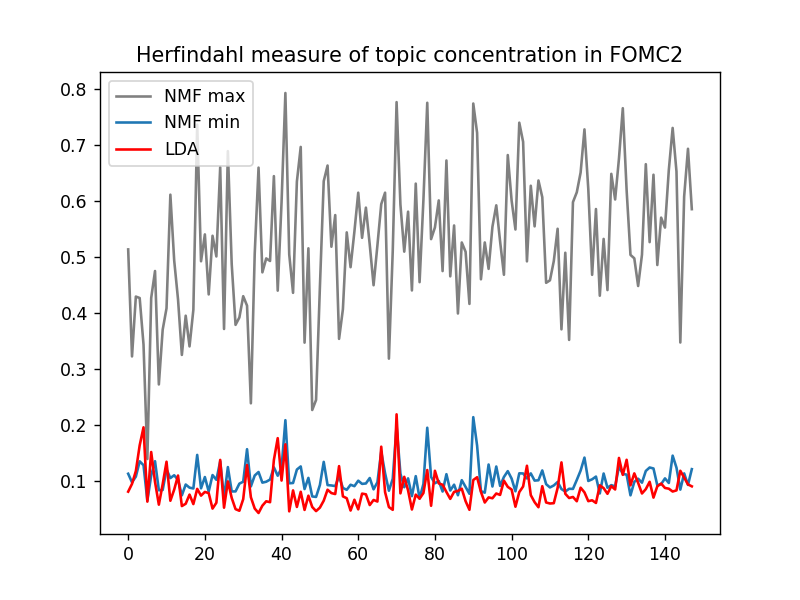

In [301]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(Herfindahl2.max(axis = 0), c = 'grey', label = 'NMF max')
plt.plot(Herfindahl2.min(axis = 0), label = 'NMF min')

theta_LDA = ldaobj.dt_avg()
plt.plot(HHI_FOMC2,c = 'r', label = 'LDA')
plt.title('Herfindahl measure of topic concentration in FOMC2')
plt.legend()

Regression result of LDA-generated HHI

In [26]:
covariates = pd.read_csv('covariates.csv')
covariates['num_stems'] = stem_num1
covariates['Intercept'] = 1
model_FOMC1 = sm.OLS(HHI_FOMC1, covariates[['Transparency','Recession','EPU','Twoday','PhDs', 'num_stems', 'Intercept']]).fit()
print(model_FOMC1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     6.091
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           1.07e-05
Time:                        14:43:25   Log-Likelihood:                 356.25
No. Observations:                 148   AIC:                            -698.5
Df Residuals:                     141   BIC:                            -677.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Transparency    -0.0135      0.005     -2.572   

In [27]:
#covariates = pd.read_csv('covariates.csv')
covariates['num_stems'] = stem_num2
covariates['Intercept'] = 1
model_FOMC2 = sm.OLS(HHI_FOMC2, covariates[['Transparency','Recession','EPU','Twoday','PhDs', 'num_stems', 'Intercept']]).fit()
print(model_FOMC2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     7.022
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           1.49e-06
Time:                        14:43:47   Log-Likelihood:                 335.65
No. Observations:                 148   AIC:                            -657.3
Df Residuals:                     141   BIC:                            -636.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Transparency    -0.0172      0.005     -3.148   

Max/min of estimates from NMF

In [ ]:
params1.to_excel('FOMC1_coef.xlsx')
bse1.to_excel('FOMC1_bse.xlsx')
params2.to_excel('FOMC2_coef.xlsx')
bse2.to_excel('FOMC2_bse.xlsx')

In [28]:
params1 = pd.read_excel("FOMC1_coef.xlsx")
bse1 = pd.read_excel("FOMC1_bse.xlsx")
params2 = pd.read_excel("FOMC2_coef.xlsx")
bse2 = pd.read_excel("FOMC2_bse.xlsx")

In [52]:
summary1 = pd.DataFrame(index = model_FOMC1.params.index)
summary1['Coef'] = model_FOMC1.params
summary1['Std Error'] = model_FOMC1.bse
summary1['Min'] = params1.min(axis = 0)
summary1['Max'] = params1.max(axis = 0)

In [53]:
#Estimate for FOMC1
summary1

,Coef,Std Error,Min,Max
Transparency,-0.013472,0.005239,-0.024576,0.058500
Recession,-0.004628,0.007575,-0.059193,0.053440
EPU,0.000019,0.000058,-0.000233,0.000868
Twoday,0.003896,0.004106,-0.027376,0.040156
PhDs,-0.004504,0.001776,-0.026966,0.002570
num_stems,0.000037,0.000007,-0.000068,0.000066
Intercept,0.110447,0.019940,0.113455,0.486646


In [54]:
summary2 = pd.DataFrame(index = model_FOMC2.params.index)
summary2['Coef'] = model_FOMC2.params
summary2['Std Error'] = model_FOMC2.bse
summary2['Min'] = params2.min(axis = 0)
summary2['Max'] = params2.max(axis = 0)

In [55]:
# Estimate for FOMC2
summary2

,Coef,Std Error,Min,Max
Transparency,-0.017172,0.005455,-0.049631,0.043976
Recession,-0.002240,0.008620,-0.090070,0.072242
EPU,-0.000014,0.000066,-0.000552,0.000657
Twoday,0.000998,0.004757,-0.017144,0.070695
PhDs,-0.000512,0.002057,-0.018036,0.021513
num_stems,0.000038,0.000006,0.000026,0.000143
Intercept,0.076847,0.023017,-0.061400,0.418538
